In [1]:
from pipeline.paths import Directories, Files
import os
import torch
import numpy as np
import gc
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if torch.cuda.is_available():
    CUDA_DEVICE = torch.device("cuda:0")
    print(f"CUDA is available. Using device: {CUDA_DEVICE}")
else:
    print("CUDA is not available. Please check your PyTorch installation. Using CPU instead.")
    CUDA_DEVICE = torch.device("cpu")

PHASE = '7'
DATA_VERSION = '13'


# Base directory
WORK_ROOT = "D:/NoahSilverberg/ngCBCT"

# NSG_CBCT Path where the raw matlab data is stored
NSG_CBCT_PATH = "D:/MitchellYu/NSG_CBCT"

# Directory with all files specific to this phase/data version
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)

DIRECTORIES = Directories(
    # mat_projections_dir=os.path.join(NSG_CBCT_PATH, "data/prj/HF/mat"),
    # pt_projections_dir=os.path.join(WORK_ROOT, "prj_pt"),
    # projections_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "projections"),
    # projections_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "projections"),
    # projections_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "projections"),
    # projections_gated_dir=os.path.join(WORK_ROOT, "gated", "prj_mat"),
    reconstructions_dir=os.path.join(PHASE_DATAVER_DIR, "reconstructions"),
    reconstructions_gated_dir=os.path.join(WORK_ROOT, "gated", "fdk_recon"),
    # reconstructions_dir=os.path.join("H:\\", "Public", "Noah", "reconstructions"),
    # reconstructions_gated_dir=os.path.join("H:\\", "Public", "Noah", "gated", "fdk_recon"),
    # images_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "images"),
    # images_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "images"),
    images_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "images"),
)

FILES = Files(DIRECTORIES)

test_scans = [('02', '01'), ('02', '02'), ('16', '01'), ('16', '02')]
# test_scans = [('08', '01'), ('10', '01'), ('14', '01'), ('14', '02'), ('15', '01'), ('20', '01')]

CUDA is available. Using device: cuda:0


# Compare matlab vs python recons

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matlab_dir = os.path.join('H:', 'Public', 'Noah', 'MK7_07')

# reconFDK_p08.HF01.HF_ns.mat
for patient, scan in test_scans:
    mat_file = f"reconFDK_p{patient}.HF{scan}.HF_ns.mat"
    python_file = FILES.get_recon_filepath('MK7_07', patient, scan, 'HF', False)

    mat_data = scipy.io.loadmat(os.path.join(matlab_dir, mat_file))['reconFDK']
    python_data = torch.load(python_file).cpu().numpy()

    # Clip both to [0, 0.04] then multiply by 25
    mat_data = np.clip(mat_data, 0, 0.04) * 25.
    python_data = np.clip(python_data, 0, 0.04) * 25.

    slice_index = 100
    mat_slice = mat_data[:, :, slice_index]
    python_slice = python_data[slice_index, :, :].T

    # # Apply circular mask to both slices
    # radius = 225
    # y, x = np.ogrid[:mat_slice.shape[0], :mat_slice.shape[1]]
    # center = (mat_slice.shape[0] // 2, mat_slice.shape[1] // 2)
    # mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
    # mat_slice[~mask] = 0
    # python_slice[~mask] = 0

    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Patient {patient}, Scan {scan}', fontsize=16)
    plt.subplot(1, 3, 1)
    plt.imshow(mat_slice, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Matlab Recon')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(python_slice, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Python Recon')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    diff_slice = np.abs(mat_slice - python_slice)
    plt.imshow(diff_slice, cmap='hot')
    plt.colorbar(label='Difference')
    plt.title(f'Abs Difference Map')
    plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Compare between two different models

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matlab_dir_MK6 = os.path.join('H:', 'Public', 'Noah', 'MK6_01')
matlab_dir_MK7 = os.path.join('H:', 'Public', 'Noah', 'MK7_07')

test_scans = [('08', '01'), ('10', '01'), ('14', '01'), ('14', '02'), ('15', '01'), ('20', '01')]
# reconFDK_p08.HF01.HF_ns.mat
for patient, scan in test_scans:
    mat_file = f"reconFDK_p{patient}.HF{scan}.HF_ns.mat"
    python_file = FILES.get_recon_filepath('MK7_07', patient, scan, 'HF', False)

    mat_data_MK6 = scipy.io.loadmat(os.path.join(matlab_dir_MK6, mat_file))['reconFDK']
    mat_data_MK7 = scipy.io.loadmat(os.path.join(matlab_dir_MK7, mat_file))['reconFDK']

    # Clip both to [0, 0.04] then multiply by 25
    mat_data_MK6 = np.clip(mat_data_MK6, 0, 0.04) * 25.
    mat_data_MK7 = np.clip(mat_data_MK7, 0, 0.04) * 25.

    slice_index = 100
    mat_slice_MK6 = mat_data_MK6[:, :, slice_index]
    mat_slice_MK7 = mat_data_MK7[:, :, slice_index]

    # # Apply circular mask to both slices
    # radius = 225
    # y, x = np.ogrid[:mat_slice_MK6.shape[0], :mat_slice_MK6.shape[1]]
    # center = (mat_slice_MK6.shape[0] // 2, mat_slice_MK6.shape[1] // 2)
    # mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
    # mat_slice_MK6[~mask] = 0
    # mat_slice_MK7[~mask] = 0

    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Patient {patient}, Scan {scan}', fontsize=16)
    plt.subplot(1, 3, 1)
    plt.imshow(mat_slice_MK6, cmap='gray', vmin=0, vmax=1)
    plt.title(f'MK6_01 Recon')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(mat_slice_MK7, cmap='gray', vmin=0, vmax=1)
    plt.title(f'MK7_07 Recon')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    diff_slice = np.abs(mat_slice_MK6 - mat_slice_MK7)
    plt.imshow(diff_slice, cmap='hot')
    plt.colorbar(label='Difference')
    plt.title(f'Abs Difference Map')
    plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# See ensemble statistics

### Plotting function

In [2]:
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
def auc(x, y):
    """Numerical integration using the trapezoidal rule (like sklearn.metrics.auc)."""
    x = np.asarray(x)
    y = np.asarray(y)
    return np.trapz(y, x)

def ensemble_plots(model_versions, apply_mask, radius, patient, scan, slice_index, accepted_value, passthrough_count=None):
    # If passthrough_count is provided, use the same model version but different passthroughs
    if passthrough_count is not None:
        # Assume only one model version is provided in model_versions[0]
        model_version = model_versions[0]
        paths = [
            FILES.get_recon_filepath(model_version, patient, scan, 'HF', False, passthrough_num=pt)
            for pt in range(passthrough_count)
        ]
    else:
        # Use each model version once
        paths = [
            FILES.get_recon_filepath(mv, patient, scan, 'HF', False)
            for mv in model_versions
        ]

    print(f"Loading reconstructions for Patient {patient}, Scan {scan}...")

    data_list = [torch.load(p).to(CUDA_DEVICE) for p in paths]

    print("Loaded scans.")

    # Clip & scale
    data_list = [torch.permute(torch.clip(d, 0, 0.04) * 25.0, (0, 2, 1)) for d in data_list]

    # Apply circular mask if requested
    if apply_mask:
        h, w = data_list[0].shape[1], data_list[0].shape[2]
        y, x = np.ogrid[:h, :w]
        center = (h // 2, w // 2)
        mask2d = (x - center[1])**2 + (y - center[0])**2 <= radius**2
        mask2d = torch.tensor(mask2d, dtype=torch.float32, device=CUDA_DEVICE)
        data_list = [d * mask2d for d in data_list]

    # Stack: shape (models/passthroughs, depth, height, width)
    ds = torch.stack(data_list, axis=0)

    # Extract the single slice from each model/passthrough: shape (n, h, w)
    slices = ds[:, slice_index, :, :]

    # Compute mean & std for that slice
    mean_slice = slices.mean(axis=0).cpu().numpy()
    std_slice = slices.std(axis=0).cpu().numpy()

    # Compute std across all voxels/slices (for histogram)
    std_all = torch.std(ds, dim=0).cpu().numpy()

    # Load ground truth for the same slice
    gt_path = FILES.get_recon_filepath('fdk', patient, scan, 'HF', gated=True)
    gt = torch.load(gt_path).to(CUDA_DEVICE)
    gt = torch.permute(torch.clip(gt, 0, 0.04) * 25.0, (0, 2, 1))
    gt_slice = gt[slice_index].cpu().numpy()

    # Compute SSIM, PSNR, MSSIM

    _, ssim_map = ssim(gt_slice, mean_slice, data_range=1.0, full=True, **{"K1": 0.03, "K2": 0.06, "win_size": 15})
    if apply_mask:
        ssim_map *= mask2d.cpu().numpy()
        mssim = ssim_map[mask2d.cpu().numpy() > 0].mean()
    else:
        mssim = ssim_map.mean()
    psnr_val = psnr(gt_slice, mean_slice, data_range=1.0)

    # Compute Spearman correlation coefficient between std and error
    error = np.abs(gt_slice - mean_slice)
    spearman_corr = np.corrcoef(std_slice.ravel(), error.ravel())[0, 1]

    print(f"PSNR: {psnr_val:.4f}")
    print(f"MSSIM: {mssim:.4f}")
    print(f"Spearman Correlation (Std vs Error): {spearman_corr:.4f}")

    # Sparsification curve
    if apply_mask:
        mask_np = mask2d.cpu().numpy()
        std_flat = std_slice[mask_np > 0].ravel()
        error_flat = error[mask_np > 0].ravel()
    else:
        std_flat = std_slice.ravel()
        error_flat = error.ravel()

    # Sort by uncertainty (std) descending
    sort_idx = np.argsort(-std_flat)
    error_sorted = error_flat[sort_idx]
    # Cumulative fraction of pixels removed (x), mean error of remaining pixels (y)
    fractions = np.linspace(0, 1, len(error_sorted))
    mean_errors = [error_sorted[int(f*len(error_sorted)):].mean() if int(f*len(error_sorted)) < len(error_sorted) else 0 for f in fractions]

    # Area under the sparsification curve (AUC)
    sparsification_auc = auc(fractions, mean_errors)
    print(f"Sparsification AUC: {sparsification_auc:.6f}")

    del ds
    for i in range(len(data_list)):
        x = data_list.pop(0)
        del x
    gc.collect()

    # Plot ground truth, mean & std maps for the selected slice, and SSIM map
    plt.figure(figsize=(22, 6))
    plt.suptitle(f'Patient {patient}, Scan {scan}', fontsize=16)

    plt.subplot(1, 4, 1)
    plt.imshow(gt_slice, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Ground Truth (Slice {slice_index})')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mean_slice, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Mean Recon (Slice {slice_index})')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(std_slice, cmap='hot', vmin=0, vmax=0.1)
    plt.title(f'Stdev (Slice {slice_index})')
    plt.colorbar(label='Std Dev')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(ssim_map, cmap='viridis', vmin=0, vmax=1)
    plt.title(f'SSIM Map\nPSNR: {psnr_val:.3f}, MSSIM: {mssim:.3f}')
    plt.colorbar(label='SSIM')
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Histograms of std in the chosen slice and over all slices
    fig, axs = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle(f'Std Dev Histograms & Sparsification (Patient {patient}, Scan {scan})', fontsize=16)

    # Histogram of std in the chosen slice
    axs[0].hist(std_slice.ravel(), bins=50, color='blue', alpha=0.7)
    max_value = std_slice.max()
    below_accepted = (std_slice < accepted_value).sum() / std_slice.size * 100
    axs[0].axvline(max_value, color='red', linestyle='--', label=f'Max Value: {max_value:.4f}')
    axs[0].axvline(accepted_value, color='green', linestyle='--', label=f'Accepted Value: {accepted_value:.4f}')
    axs[0].set_title(f'Std Dev Histogram (Slice {slice_index})')
    axs[0].set_xlabel('Std Dev')
    axs[0].set_ylabel('Frequency')
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].annotate(f'{below_accepted:.2f}% below accepted value',
                    xy=(accepted_value, axs[0].get_ylim()[1] * 0.8),
                    color='green', fontsize=10)

    # Histogram of std over all slices
    axs[1].hist(std_all.ravel(), bins=50, color='green', alpha=0.7)
    max_value_all = std_all.max()
    below_accepted_all = (std_all < accepted_value).sum() / std_all.size * 100
    axs[1].axvline(max_value_all, color='red', linestyle='--', label=f'Max Value: {max_value_all:.4f}')
    axs[1].axvline(accepted_value, color='green', linestyle='--', label=f'Accepted Value: {accepted_value:.4f}')
    axs[1].set_title('Std Dev Histogram (All Slices)')
    axs[1].set_xlabel('Std Dev')
    axs[1].set_ylabel('Frequency')
    axs[1].set_yscale('log')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].annotate(f'{below_accepted_all:.2f}% below accepted value',
                    xy=(accepted_value, axs[1].get_ylim()[1] * 0.8),
                    color='green', fontsize=10)

    # Sparsification curve
    axs[2].plot(fractions, mean_errors, color='purple', label=f'AUC={sparsification_auc:.4f}')
    axs[2].set_title('Sparsification Curve\n(Mean Error vs Fraction Removed)')
    axs[2].set_xlabel('Fraction of Most Uncertain Voxels Removed')
    axs[2].set_ylabel('Mean Absolute Error (Remaining)')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    del mean_slice, std_slice, std_all, gt, gt_slice, ssim_map, error, error_flat, std_flat, fractions, mean_errors
    gc.collect()

## PD domain reconstruction

### With mask

Loading reconstructions for Patient 02, Scan 01...
Loaded scans.
PSNR: 30.5749
MSSIM: 0.8834
Spearman Correlation (Std vs Error): 0.6446
Sparsification AUC: 0.012374


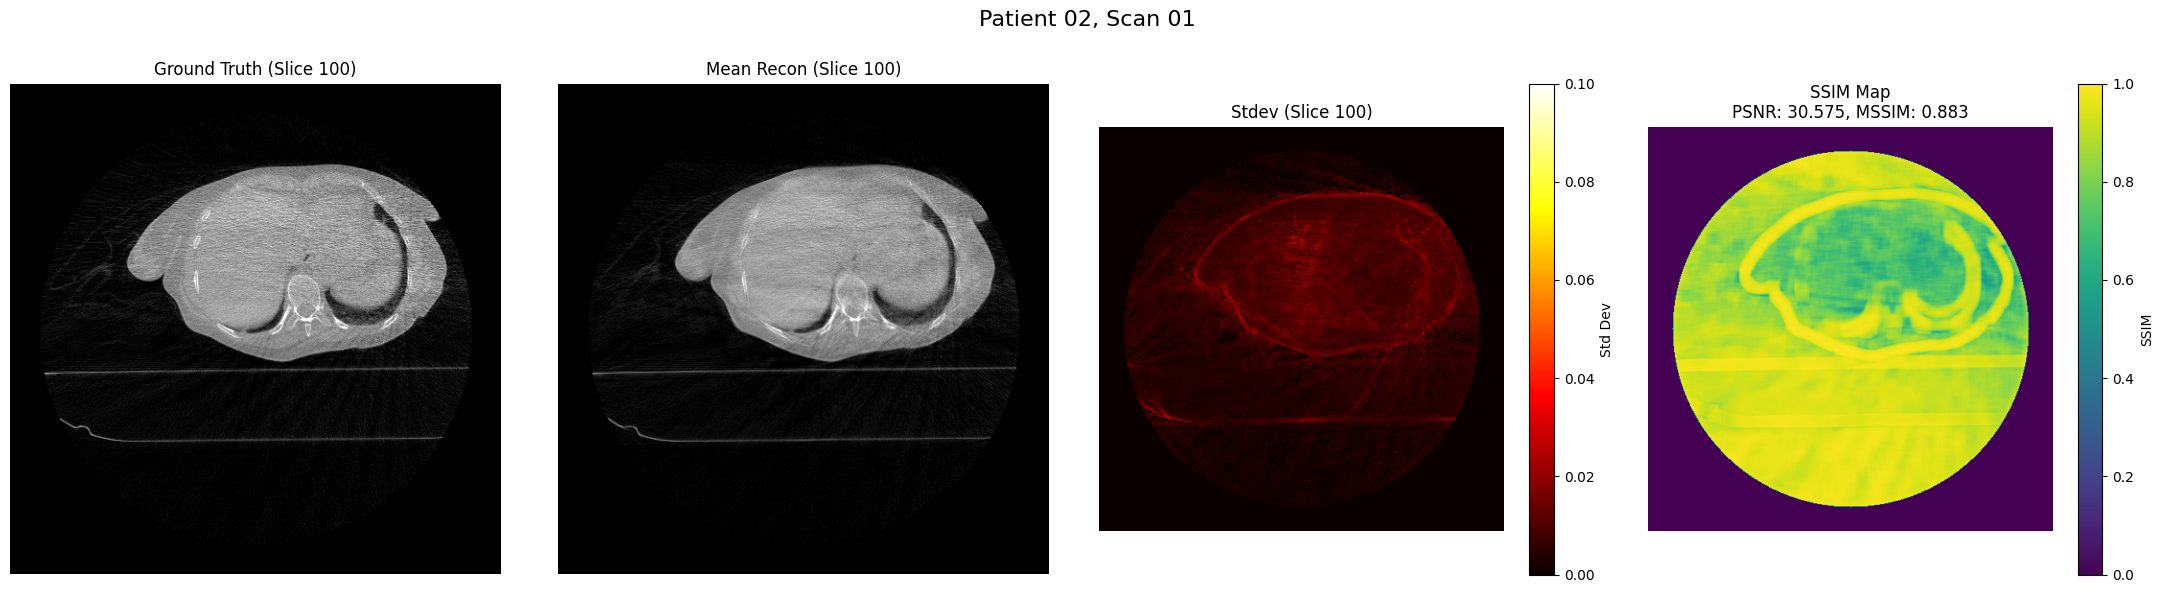

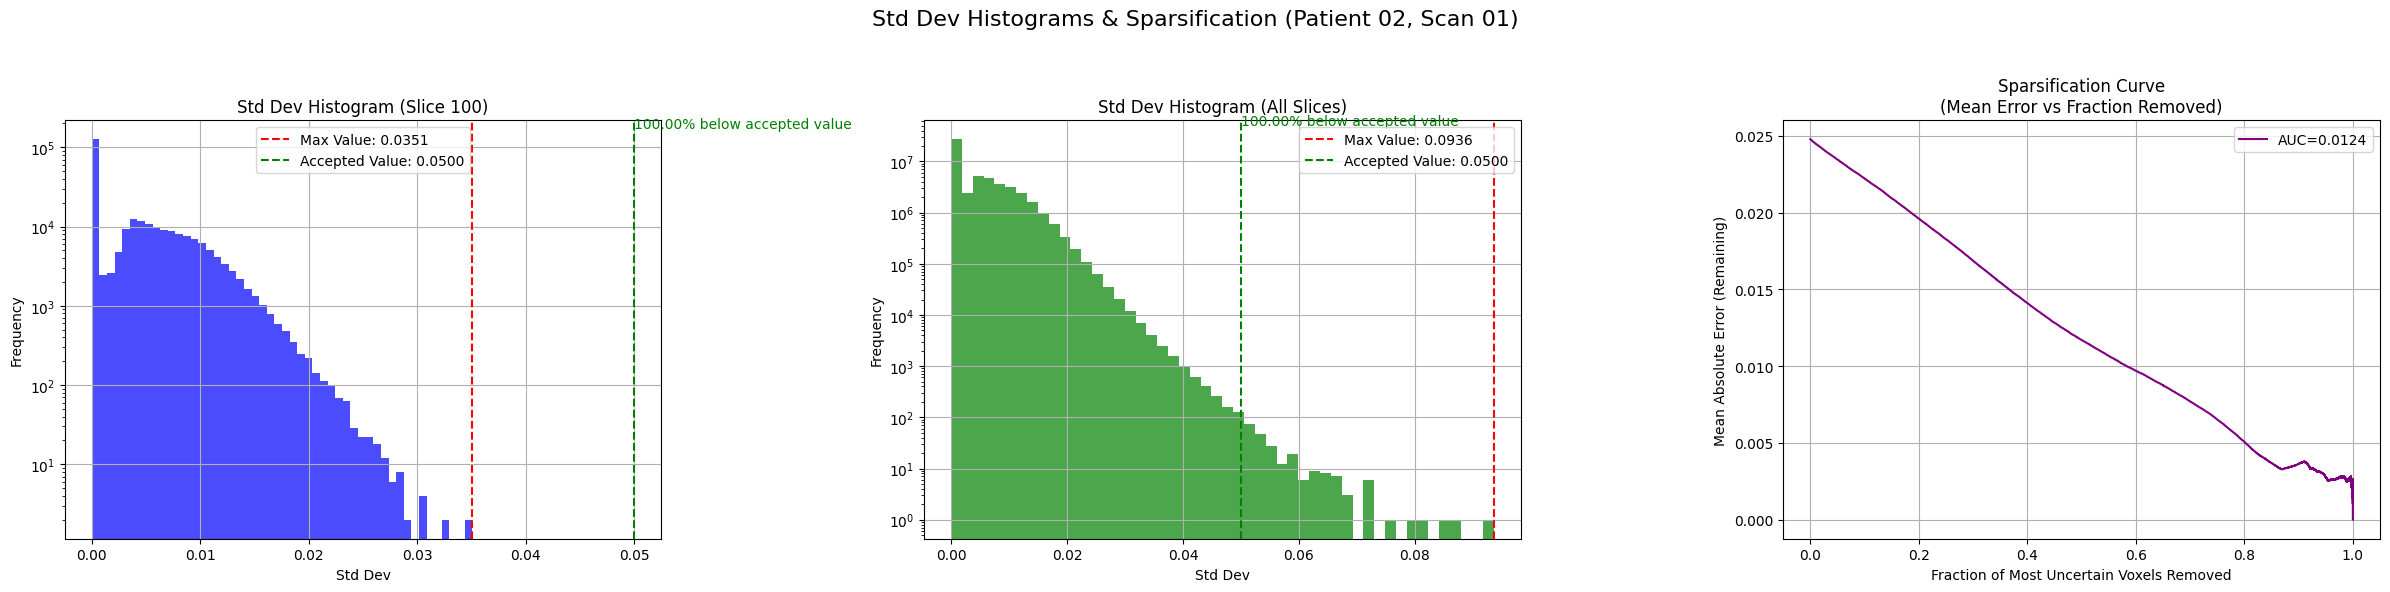

Loading reconstructions for Patient 02, Scan 02...
Loaded scans.
PSNR: 31.9612
MSSIM: 0.9150
Spearman Correlation (Std vs Error): 0.6386
Sparsification AUC: 0.010621


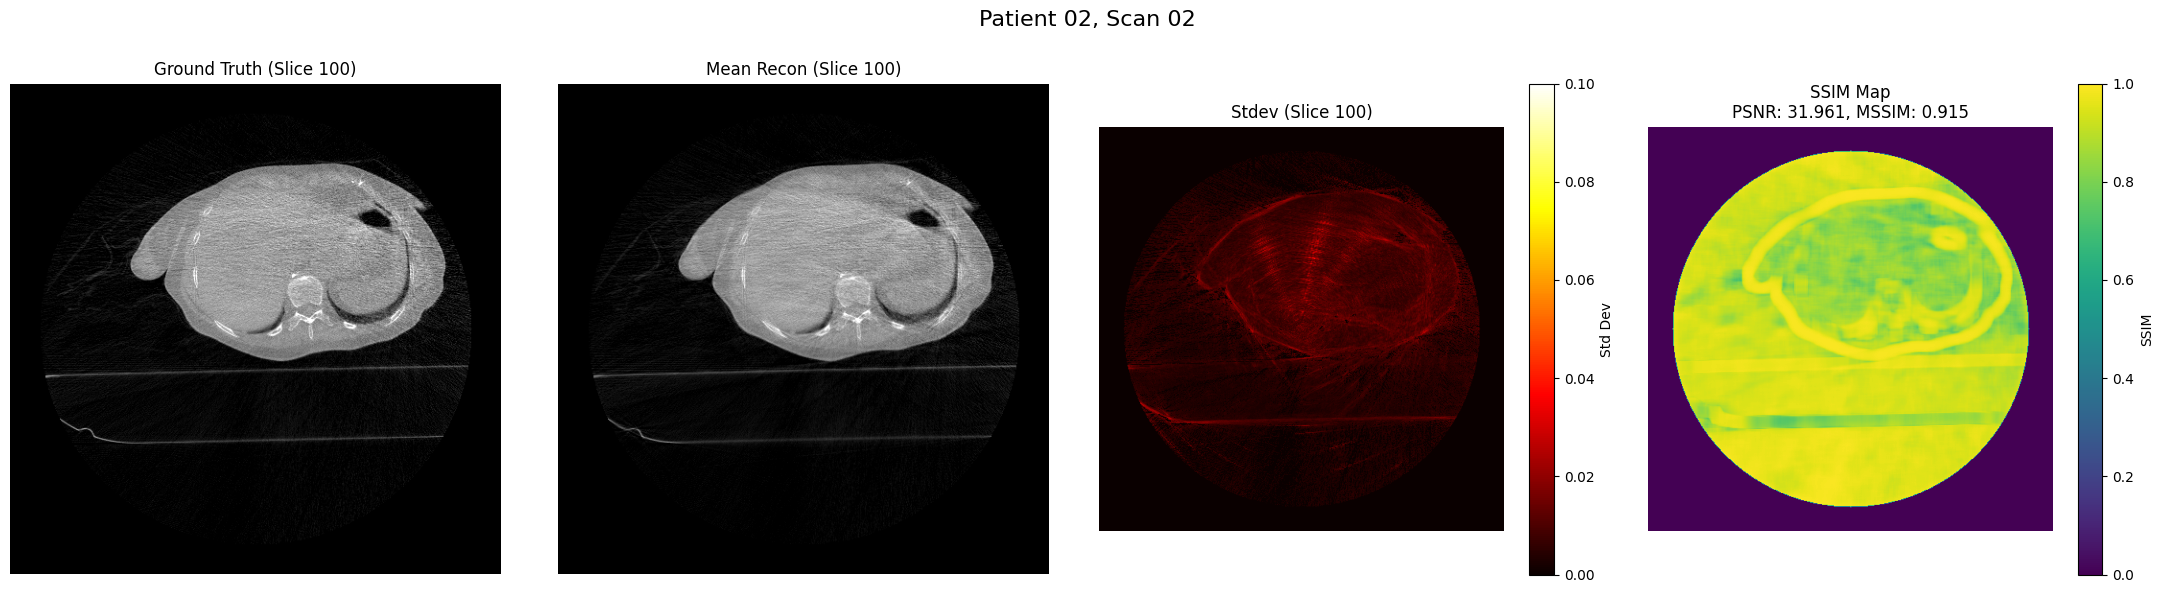

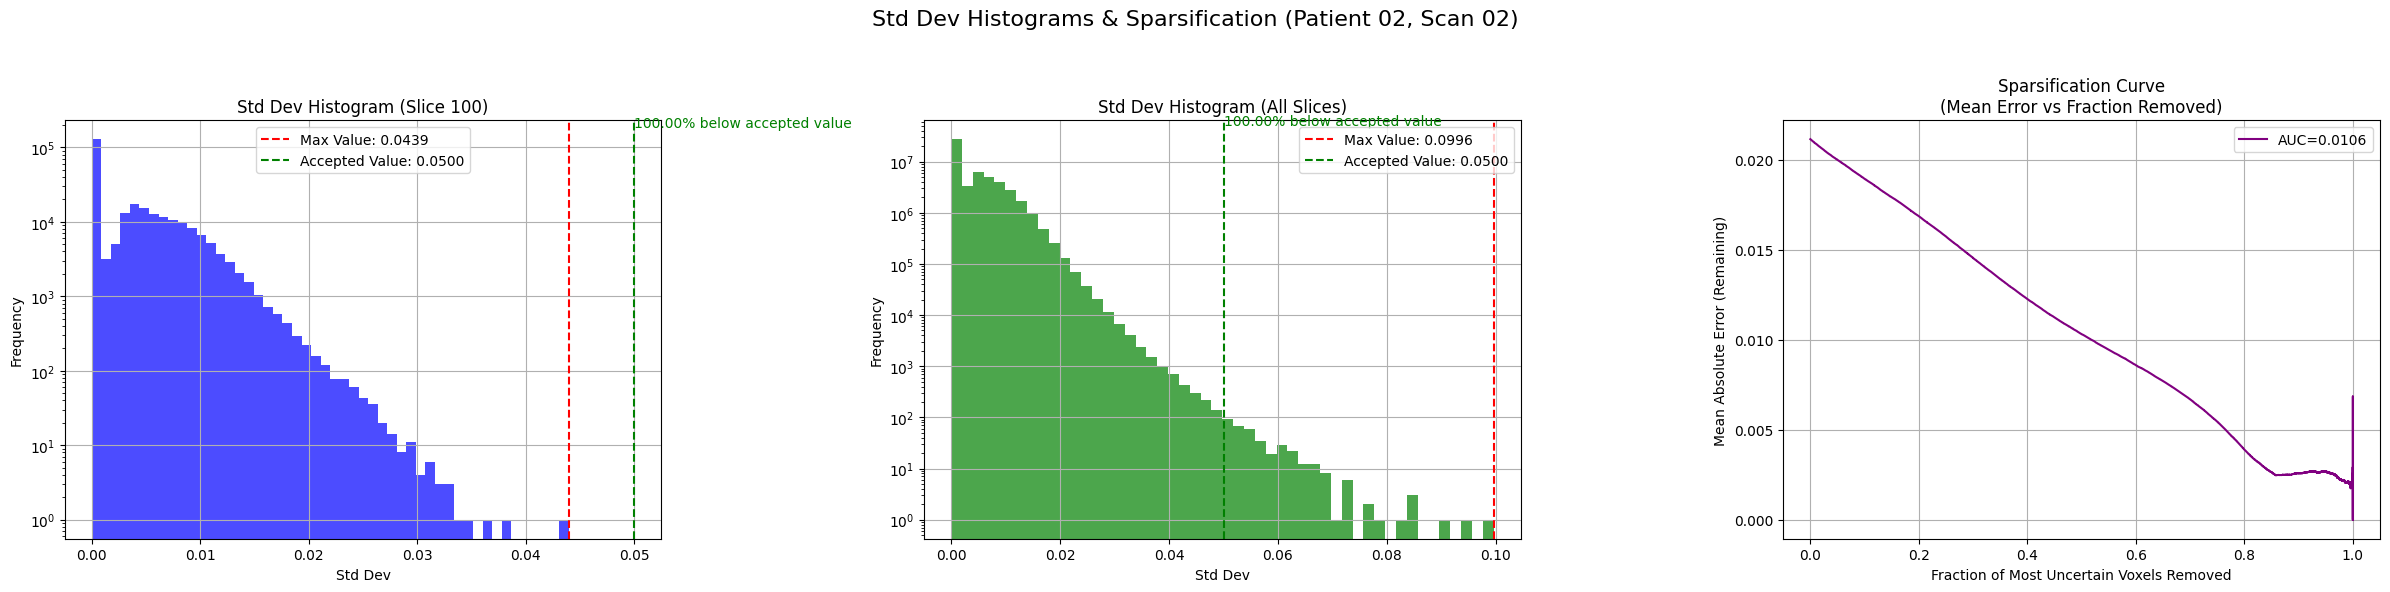

Loading reconstructions for Patient 16, Scan 01...
Loaded scans.
PSNR: 33.3493
MSSIM: 0.9259
Spearman Correlation (Std vs Error): 0.6333
Sparsification AUC: 0.010524


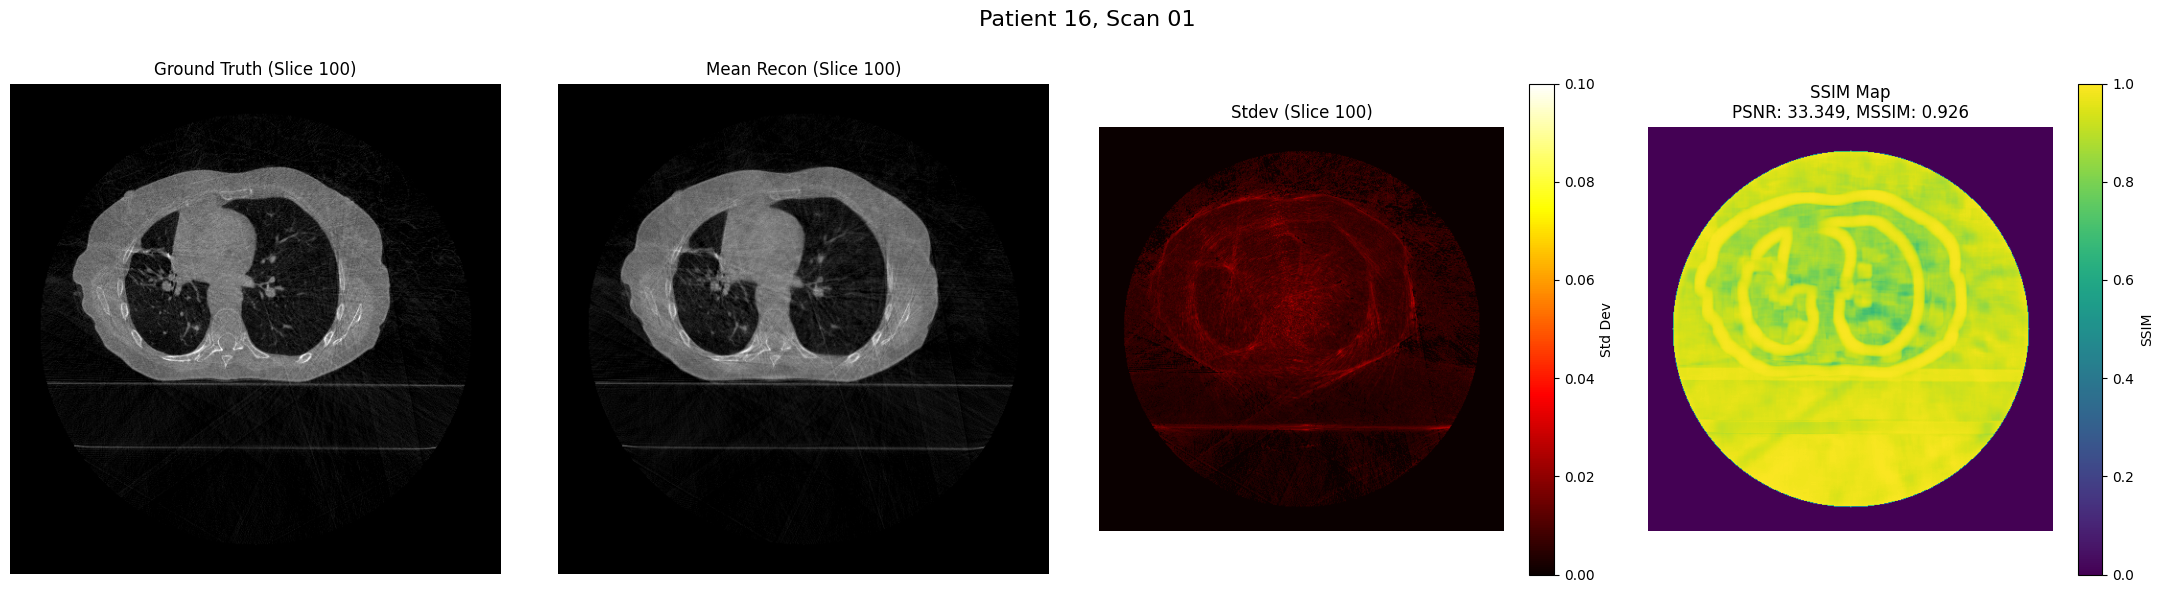

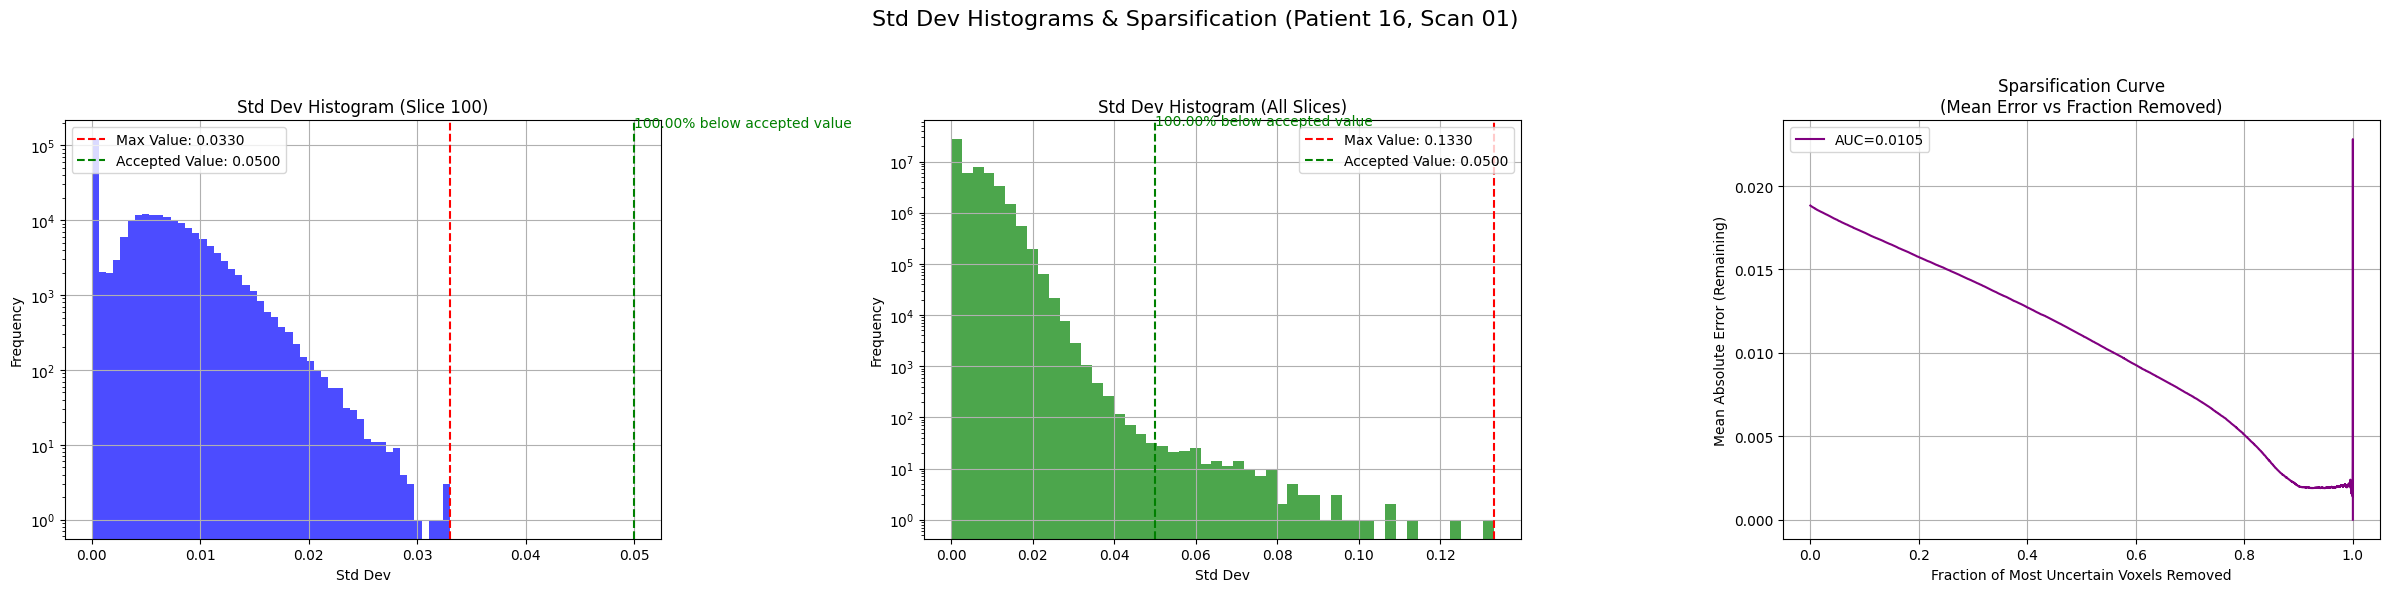

Loading reconstructions for Patient 16, Scan 02...
Loaded scans.
PSNR: 34.2380
MSSIM: 0.9392
Spearman Correlation (Std vs Error): 0.6416
Sparsification AUC: 0.008706


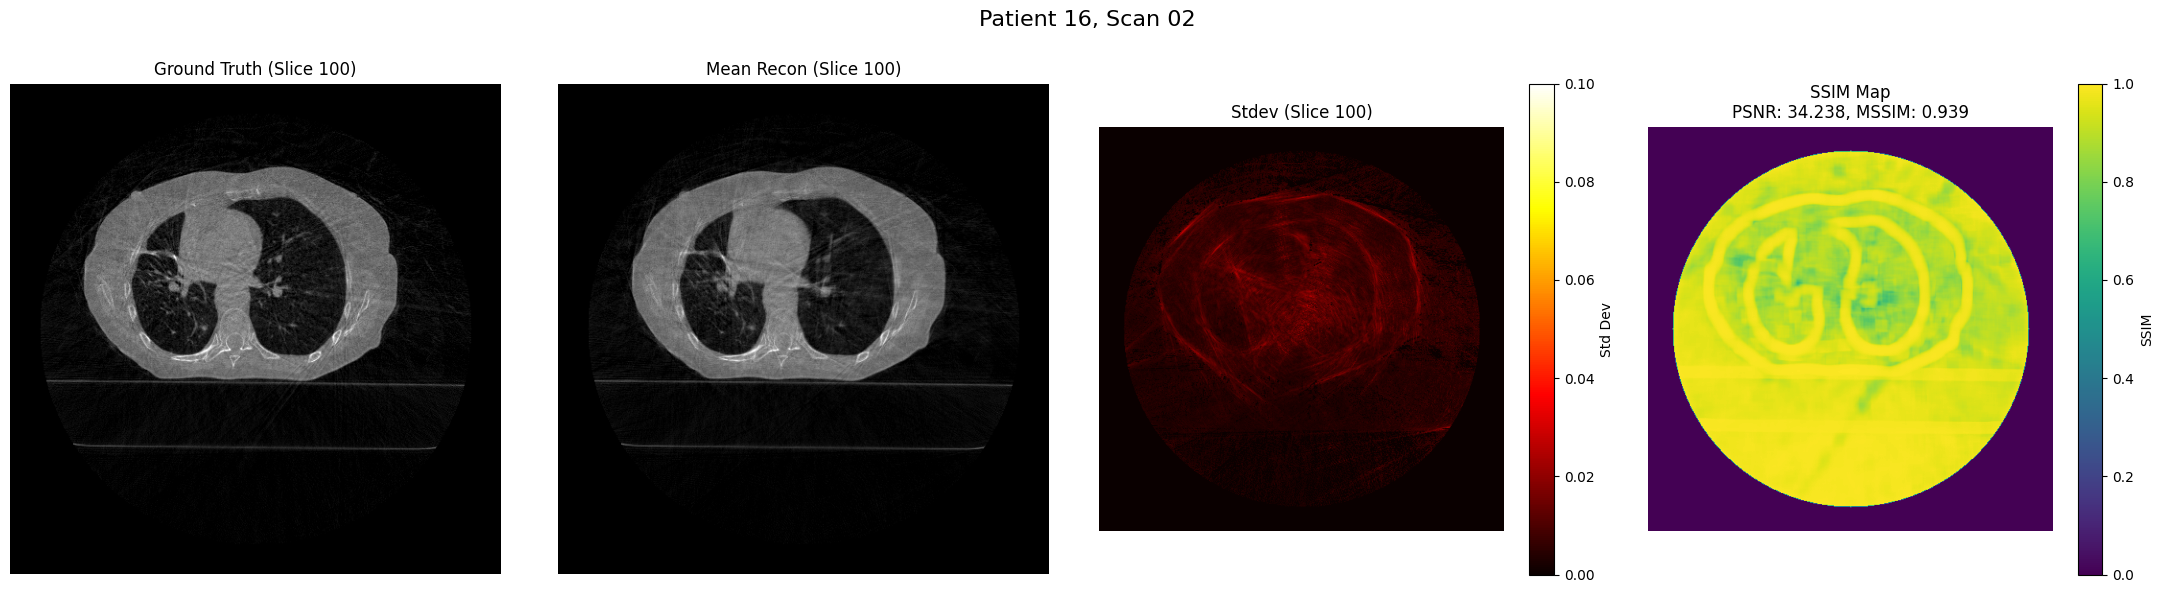

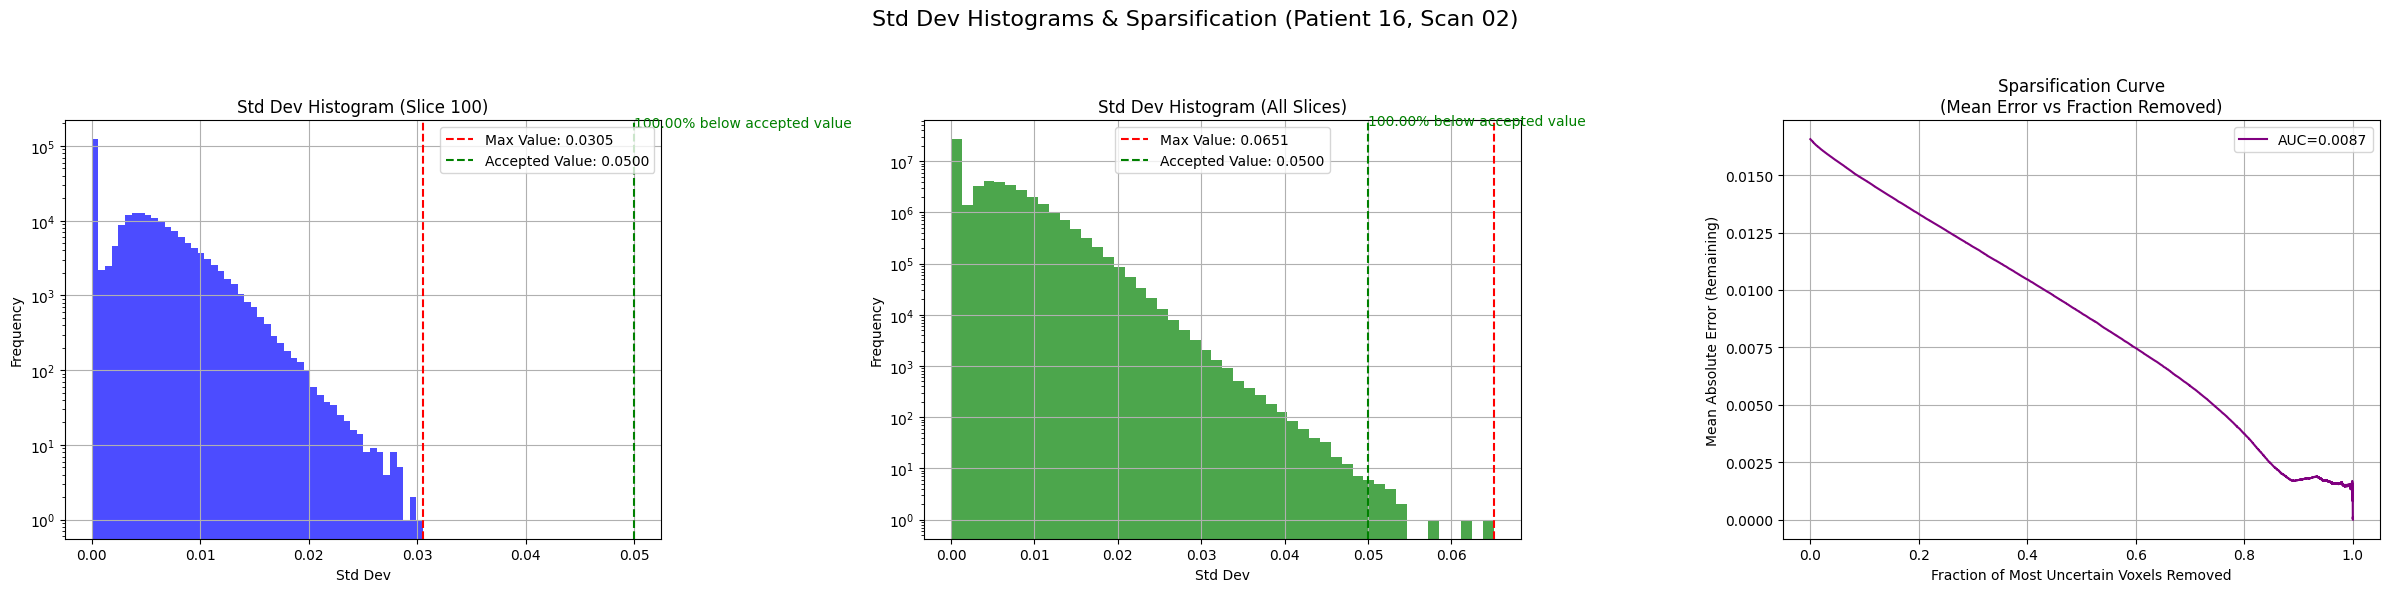

In [3]:
# Set the slice index to plot
slice_index = 100

# Model versions to compare
# model_versions = [f"MK7_{i:02d}" for i in range(1, 8)]
model_versions = ['MK7_MCDROPOUT_30_pct']
passthrough_count = 16

# Apply circular mask?
apply_mask = True
radius = 225  # Radius of the circular mask

# Accepted value for comparison
accepted_value = 0.05  # User-defined parameter

for patient, scan in test_scans:
    ensemble_plots(model_versions, apply_mask, radius, patient, scan, slice_index, accepted_value, passthrough_count=passthrough_count)

### Without mask

Loading reconstructions for Patient 02, Scan 01...
Loaded scans.
PSNR: 30.9369
MSSIM: 0.9255


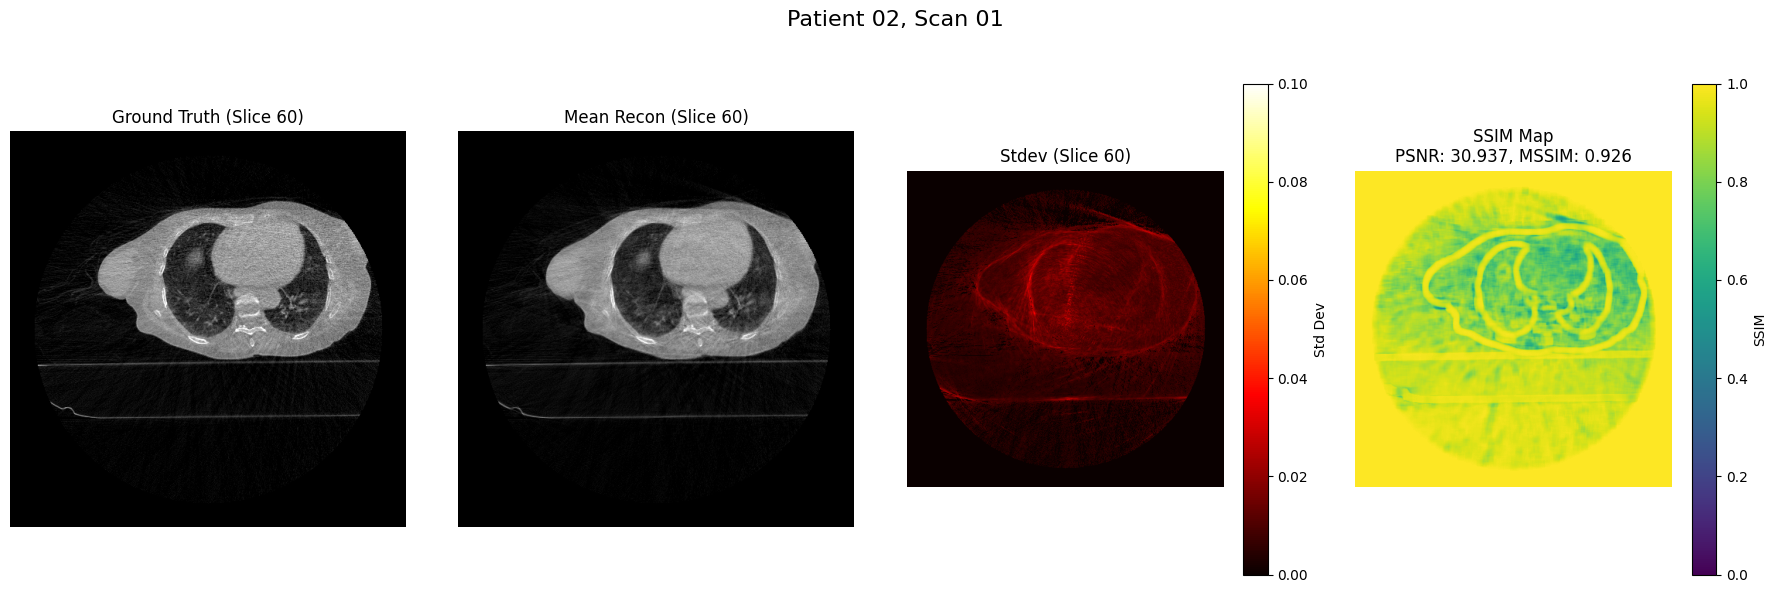

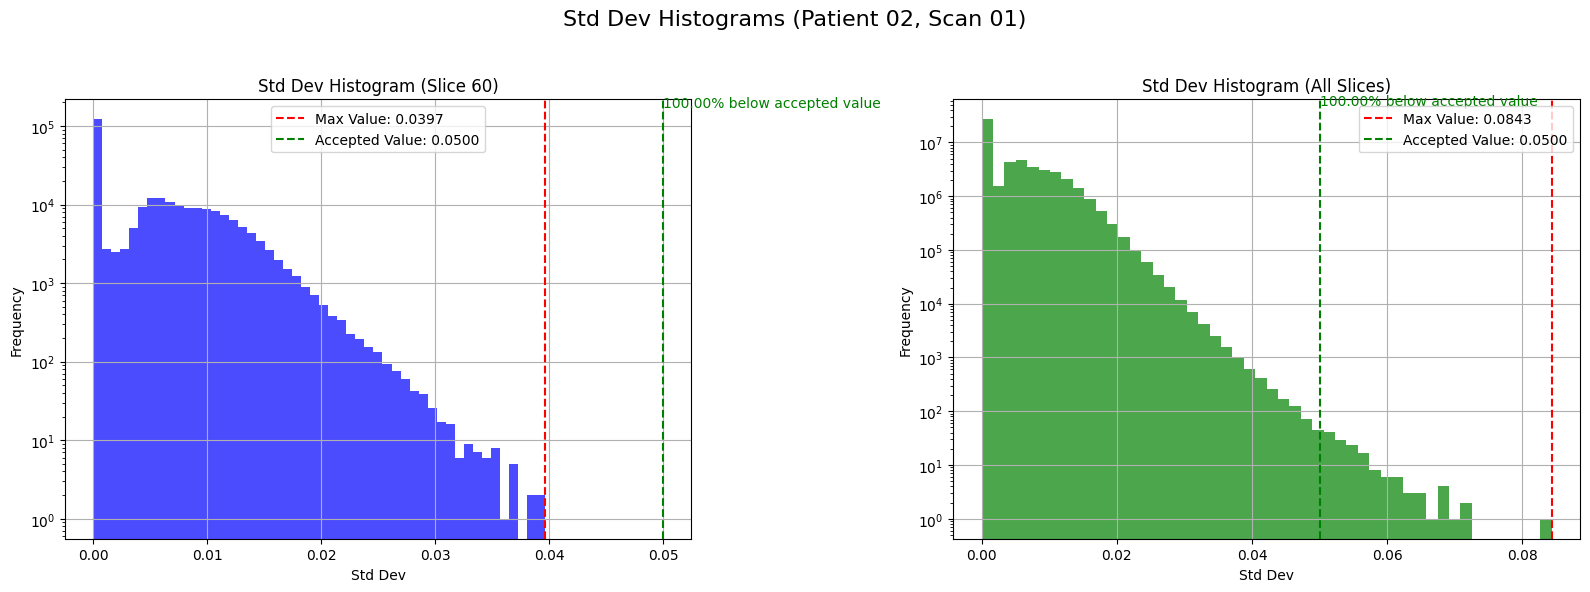

In [4]:
# Set the slice index to plot
slice_index = 60

# Model versions to compare
# model_versions = [f"MK7_{i:02d}" for i in range(1, 8)]
model_versions = ['MK7_MCDROPOUT_30_pct']
passthrough_count = 30


# Apply circular mask?
apply_mask = False
radius = 225  # Radius of the circular mask

# Accepted value for comparison
accepted_value = 0.05  # User-defined parameter

for patient, scan in test_scans:
    ensemble_plots(model_versions, apply_mask, radius, patient, scan, slice_index, accepted_value, passthrough_count=passthrough_count)

## ID domain output

### With mask

In [ ]:
# Set the slice index to plot
slice_index = 80

# Model versions to compare
model_versions = ["run1", "run2", "run3"]

# Apply circular mask?
apply_mask = True
radius = 225  # Radius of the circular mask

# Accepted value for comparison
accepted_value = 0.05  # User-defined parameter

for patient, scan in test_scans:
    ensemble_plots(model_versions, apply_mask, radius, patient, scan, slice_index, accepted_value)

### Without mask

In [ ]:
# Set the slice index to plot
slice_index = 80

# Model versions to compare
model_versions = ["run1", "run2", "run3"]

# Apply circular mask?
apply_mask = True
radius = 225  # Radius of the circular mask

# Accepted value for comparison
accepted_value = 0.05  # User-defined parameter

for patient, scan in test_scans:
    ensemble_plots(model_versions, apply_mask, radius, patient, scan, slice_index, accepted_value)